# Coursework 2 – Replication of Attention U-Net on 4-band Amazon

This notebook reproduces the Attention U-Net baseline on the 4-band Amazon dataset
from:

> John, D. & Zhang, C. (2022). *An attention-based U-Net for detecting deforestation within satellite sensor imagery.*

I strictly follow the original paper settings for the 4-band Amazon dataset:
- Input size: 512 × 512 × 4 (RGB + NIR)
- Filters: 16, 32, 64, 128 with 256 in the bottleneck
- Optimiser: Adam, learning rate 0.0005
- Loss: Binary Cross-Entropy
- Epochs: 60
- No data augmentation for 4-band datasets


## 1. Environment Setup

I first check the Python and TensorFlow versions and fix a random seed to improve reproducibility.


In [1]:
import os, sys, random
import numpy as np
import tensorflow as tf

print("Python:", sys.version)
print("TensorFlow:", tf.__version__)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
TensorFlow: 2.19.0


## 2. Repository Setup

I clone the original GitHub repository that accompanies the paper.  
This repository contains the preprocessing scripts and experimental notebook used by the authors.


In [2]:
# Clone the original repository (fresh)
!git clone https://github.com/davej23/attention-mechanism-unet.git

# Enter the repo
%cd /content/attention-mechanism-unet
!ls


Cloning into 'attention-mechanism-unet'...
remote: Enumerating objects: 690, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 690 (delta 36), reused 78 (delta 36), pack-reused 612 (from 1)
Receiving objects: 100% (690/690), 153.27 MiB | 16.45 MiB/s, done.
Resolving deltas: 100% (291/291), done.
/content/attention-mechanism-unet
dataset			  predictor.py
Experimentation-Code.pdf  preprocess-4band-amazon-data.py
Experimentation.ipynb	  preprocess-4band-atlantic-forest-data.py
figures			  preprocess-rgb-data.py
Figures.ipynb		  README.md
metrics			  requirements.txt
models


## 3. Dependencies

The original implementation relies on TensorFlow/Keras for deep learning and several geospatial libraries  
(`rasterio`, `rioxarray`, `GDAL`, etc.) to read multi-band satellite imagery.

I install the required Python and system dependencies below.


In [3]:
# Make sure we are in the repo
%cd /content/attention-mechanism-unet
print("CWD:", os.getcwd())

#  install original requirements
!pip install -q -r requirements.txt
!pip install -q Pillow rasterio rioxarray geopandas earthpy scikit-image
!pip install -q rasterio --no-binary rasterio
!apt-get update -y
!apt-get install -y gdal-bin libgdal-dev


/content/attention-mechanism-unet
CWD: /content/attention-mechanism-unet
ERROR: Could not find a version that satisfies the requirement PIL (from versions: none)
ERROR: No matching distribution found for PIL
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 82.0 MB/s eta 0:00:00
Hit:1 https://cli.github.com/packages stable InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [83.6 kB]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,201 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:7 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:9 ht

## 4. Downloading the 4-band Amazon Dataset

The 4-band Amazon dataset (RGB + NIR) used in the paper is hosted on Zenodo.  
I download the `AMAZON.rar` archive into a temporary folder.


In [4]:
%cd /content/attention-mechanism-unet

# Create folder to hold raw archive
!mkdir -p AMAZON_raw

# Download 4-band Amazon dataset (AMAZON.rar) from Zenodo
!wget -O AMAZON_raw/AMAZON.rar "https://zenodo.org/records/4498086/files/AMAZON.rar?download=1"

# Check file
!ls -lh AMAZON_raw


/content/attention-mechanism-unet
--2025-12-09 18:39:53--  https://zenodo.org/records/4498086/files/AMAZON.rar?download=1
Resolving zenodo.org (zenodo.org)... 188.185.48.75, 137.138.52.235, 188.185.43.153, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1173939349 (1.1G) [application/octet-stream]
Saving to: ‘AMAZON_raw/AMAZON.rar’

AMAZON_raw/AMAZON.r 100%[===================>]   1.09G  1.39MB/s    in 13m 6s  

2025-12-09 18:53:00 (1.42 MB/s) - ‘AMAZON_raw/AMAZON.rar’ saved [1173939349/1173939349]

total 1.1G
-rw-r--r-- 1 root root 1.1G Dec  9 18:53 AMAZON.rar


## 5. Extracting and Preparing the Dataset

I extract the `AMAZON.rar` archive and move the resulting `AMAZON` folder  
into the repository root. This yields the directory structure expected by the authors' code:

- `AMAZON/Training/image` and `AMAZON/Training/label`
- `AMAZON/Validation/images` and `AMAZON/Validation/masks`
- `AMAZON/Test/image` and `AMAZON/Test/mask`


In [5]:
!pip install pyunpack patool rarfile
from pyunpack import Archive

%cd /content/attention-mechanism-unet

archive_path = "AMAZON_raw/AMAZON.rar"
print("Archive path:", archive_path)

# Extract into AMAZON_raw
Archive(archive_path).extractall("AMAZON_raw")

print("AMAZON_raw contents:", os.listdir("AMAZON_raw"))

# Move AMAZON folder to repo root so path = ./AMAZON/
import shutil

src = "AMAZON_raw/AMAZON"
dst = "AMAZON"

if not os.path.exists(dst):
    shutil.move(src, dst)
else:
    print("AMAZON already exists at", dst)

print("AMAZON contents:", os.listdir("AMAZON"))
print("Training:", os.listdir("AMAZON/Training"))
print("Validation:", os.listdir("AMAZON/Validation"))
print("Test:", os.listdir("AMAZON/Test"))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 kB 8.0 MB/s eta 0:00:00
/content/attention-mechanism-unet
Archive path: AMAZON_raw/AMAZON.rar
AMAZON_raw contents: ['AMAZON', 'AMAZON.rar']
AMAZON contents: ['Training', 'Test', 'Validation']
Training: ['image', 'label']
Validation: ['masks', 'images']
Test: ['image', 'mask']


## 6. Data Ingestion (4-band Amazon)

In this section, we follow the authors' Experimentation notebook and directly read the  
4-band GeoTIFF tiles from the `AMAZON` folder using `rioxarray`.  

For each tile:
- We load the 4-band image as an array of shape `(bands, H, W)`
- We apply per-tile min–max normalisation to map pixel values to `[0, 1]`
- We load the corresponding binary mask (deforestation vs. non-deforestation)

We do this separately for the Training, Validation and Test splits.


Training tiles found: 499
Validation tiles: 100
Test tiles: 20

Example loaded image shape: (4, 512, 512)
Example loaded mask shape: (1, 512, 512)


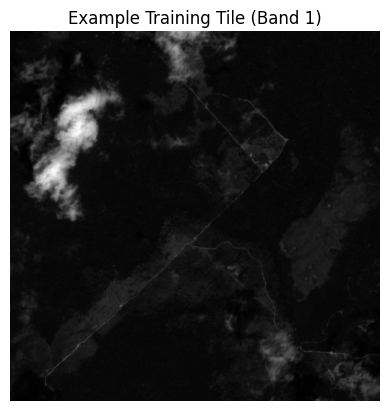

In [6]:
import os
import numpy as np
import rioxarray as rxr
import matplotlib.pyplot as plt

base_dir = "./AMAZON/"

# ░░░ 1. Load Training Images ░░░
train_img_dir = os.path.join(base_dir, "Training", "image")
train_mask_dir = os.path.join(base_dir, "Training", "label")

train_files = sorted(os.listdir(train_img_dir))
print("Training tiles found:", len(train_files))

train_images = []
train_masks = []

for f in train_files:
    img = np.array(rxr.open_rasterio(os.path.join(train_img_dir, f)))
    # per-tile min-max normalisation
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    train_images.append(img)

    mask = np.array(rxr.open_rasterio(os.path.join(train_mask_dir, f)))
    train_masks.append(mask)

# ░░░ 2. Load Validation Images ░░░
val_img_dir = os.path.join(base_dir, "Validation", "images")
val_mask_dir = os.path.join(base_dir, "Validation", "masks")

val_files = sorted(os.listdir(val_img_dir))
print("Validation tiles:", len(val_files))

val_images = []
val_masks = []

for f in val_files:
    img = np.array(rxr.open_rasterio(os.path.join(val_img_dir, f)))
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    val_images.append(img)

    mask = np.array(rxr.open_rasterio(os.path.join(val_mask_dir, f)))
    val_masks.append(mask)

# ░░░ 3. Load Test Images ░░░
test_img_dir = os.path.join(base_dir, "Test", "image")
test_mask_dir = os.path.join(base_dir, "Test", "mask")

test_files = sorted(os.listdir(test_img_dir))
print("Test tiles:", len(test_files))

test_images = []
test_masks = []

for f in test_files:
    img = np.array(rxr.open_rasterio(os.path.join(test_img_dir, f)))
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    test_images.append(img)

    mask = np.array(rxr.open_rasterio(os.path.join(test_mask_dir, f)))
    test_masks.append(mask)

print("\nExample loaded image shape:", train_images[0].shape)
print("Example loaded mask shape:", train_masks[0].shape)

# show first band
plt.imshow(train_images[0][0, :, :], cmap="gray")
plt.title("Example Training Tile (Band 1)")
plt.axis("off")
plt.show()


## 7. Preprocessing and Dataset Construction

We now convert the loaded lists into NumPy arrays and reshape them into the format  
expected by Keras: `(N, H, W, C)` for images and `(N, H, W, 1)` for masks.

Following the experimental setup in the paper, we only use **250 tiles for training**,  
while keeping the full validation and test sets.


In [7]:
import numpy as np

# 1) Convert lists to numpy arrays
train_images = np.stack(train_images)   # shape: (N_train_full, bands, H, W)
train_masks  = np.stack(train_masks)

val_images   = np.stack(val_images)
val_masks    = np.stack(val_masks)

test_images  = np.stack(test_images)
test_masks   = np.stack(test_masks)

print("Raw array shapes:")
print("train_images:", train_images.shape)
print("train_masks:",  train_masks.shape)
print("val_images:",   val_images.shape)
print("val_masks:",    val_masks.shape)
print("test_images:",  test_images.shape)
print("test_masks:",   test_masks.shape)

# 2) Rearrange axes from (N, bands, H, W) → (N, H, W, bands)
train_images = np.transpose(train_images, (0, 2, 3, 1))
val_images   = np.transpose(val_images,   (0, 2, 3, 1))
test_images  = np.transpose(test_images,  (0, 2, 3, 1))

# 3) Ensure masks are shaped (N, H, W, 1)
def fix_mask_shape(mask_array):
    if mask_array.ndim == 4 and mask_array.shape[1] == 1:
        # (N,1,H,W) -> (N,H,W,1)
        return np.transpose(mask_array, (0, 2, 3, 1))
    elif mask_array.ndim == 3:
        # (N,H,W) -> (N,H,W,1)
        return mask_array[..., np.newaxis]
    else:
        return mask_array

train_masks = fix_mask_shape(train_masks)
val_masks   = fix_mask_shape(val_masks)
test_masks  = fix_mask_shape(test_masks)

print("\nAfter axis rearrangement:")
print("train_images:", train_images.shape)
print("train_masks:",  train_masks.shape)
print("val_images:",   val_images.shape)
print("val_masks:",    val_masks.shape)
print("test_images:",  test_images.shape)
print("test_masks:",   test_masks.shape)

# 4) Select 250 training samples as used in the original paper
np.random.seed(42)
idx = np.random.permutation(train_images.shape[0])[:250]

X_train = train_images[idx]
y_train = train_masks[idx]

X_val = val_images
y_val = val_masks

X_test = test_images
y_test = test_masks

print("\nFinal dataset shapes:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_val:",   X_val.shape)
print("y_val:",   y_val.shape)
print("X_test:",  X_test.shape)
print("y_test:",  y_test.shape)


Raw array shapes:
train_images: (499, 4, 512, 512)
train_masks: (499, 1, 512, 512)
val_images: (100, 4, 512, 512)
val_masks: (100, 1, 512, 512)
test_images: (20, 4, 512, 512)
test_masks: (20, 1, 512, 512)

After axis rearrangement:
train_images: (499, 512, 512, 4)
train_masks: (499, 512, 512, 1)
val_images: (100, 512, 512, 4)
val_masks: (100, 512, 512, 1)
test_images: (20, 512, 512, 4)
test_masks: (20, 512, 512, 1)

Final dataset shapes:
X_train: (250, 512, 512, 4)
y_train: (250, 512, 512, 1)
X_val: (100, 512, 512, 4)
y_val: (100, 512, 512, 1)
X_test: (20, 512, 512, 4)
y_test: (20, 512, 512, 1)


## 8. Model Definition – Attention U-Net

I now implement the Attention U-Net architecture described in the paper.  



In [8]:
import tensorflow as tf
from tensorflow.keras import backend as K

def iou_metric(y_true, y_pred, smooth=1e-6):
    # Ensure both tensors are float32
    y_true = K.cast(y_true, "float32")
    y_pred = K.cast(y_pred, "float32")

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

def f1_metric(y_true, y_pred, smooth=1e-6):
    # Ensure both tensors are float32
    y_true = K.cast(y_true, "float32")
    y_pred = K.cast(y_pred, "float32")

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    intersection = K.sum(y_true_f * y_pred_f)
    precision = (intersection + smooth) / (K.sum(y_pred_f) + smooth)
    recall = (intersection + smooth) / (K.sum(y_true_f) + smooth)
    f1 = 2.0 * precision * recall / (precision + recall + smooth)
    return f1


In [9]:
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D,
    Concatenate, Activation, BatchNormalization
)
from tensorflow.keras.models import Model

def conv_block(x, filters, kernel_size=3, padding="same", activation="relu"):
    x = Conv2D(filters, kernel_size, padding=padding)(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Conv2D(filters, kernel_size, padding=padding)(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    return x

def attention_gate(x, g, inter_channels):
    """
    Attention gate:
    x: encoder feature map (skip connection)
    g: decoder feature map (gating signal)
    """
    theta_x = Conv2D(inter_channels, 1, padding="same")(x)
    phi_g   = Conv2D(inter_channels, 1, padding="same")(g)
    add_xg  = Activation("relu")(theta_x + phi_g)
    psi     = Conv2D(1, 1, padding="same")(add_xg)
    psi     = Activation("sigmoid")(psi)
    # broadcasting psi over channels of x
    y = x * psi
    return y

def build_attention_unet_4band(input_shape):
    inputs = Input(shape=input_shape)

    # Encoder
    c1 = conv_block(inputs, 16)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, 32)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, 64)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = conv_block(p3, 128)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = conv_block(p4, 256)

    # Decoder + attention gates
    u6 = UpSampling2D((2, 2))(c5)
    g4 = attention_gate(c4, u6, inter_channels=128)
    u6 = Concatenate()([u6, g4])
    c6 = conv_block(u6, 128)

    u7 = UpSampling2D((2, 2))(c6)
    g3 = attention_gate(c3, u7, inter_channels=64)
    u7 = Concatenate()([u7, g3])
    c7 = conv_block(u7, 64)

    u8 = UpSampling2D((2, 2))(c7)
    g2 = attention_gate(c2, u8, inter_channels=32)
    u8 = Concatenate()([u8, g2])
    c8 = conv_block(u8, 32)

    u9 = UpSampling2D((2, 2))(c8)
    g1 = attention_gate(c1, u9, inter_channels=16)
    u9 = Concatenate()([u9, g1])
    c9 = conv_block(u9, 16)

    outputs = Conv2D(1, (1, 1), activation="sigmoid")(c9)

    model = Model(inputs=[inputs], outputs=[outputs], name="AttentionUNet_4band")
    return model

# Build model using the shapes from your data
input_shape = X_train.shape[1:]  # (512, 512, 4)
model = build_attention_unet_4band(input_shape)
model.summary()


Model: "AttentionUNet_4band"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │        592 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512, 512,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │      2,320 │ activation[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │      9,248 │ activation_2[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_4[0][0]  

 Total params: 2,034,661 (7.76 MB)

 Trainable params: 2,031,717 (7.75 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [10]:
learning_rate = 5e-4

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss="binary_crossentropy",
    metrics=["accuracy", iou_metric, f1_metric]
)

print("Model compiled.")


Model compiled.


In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

EPOCHS = 60
BATCH_SIZE = 2
CHECKPOINT_PATH = "attention_unet_4band_amazon_best.h5"

callbacks = [
    ModelCheckpoint(
        CHECKPOINT_PATH,
        monitor="val_iou_metric",
        mode="max",
        save_best_only=True,
        save_weights_only=False,
        verbose=1,
    ),
    EarlyStopping(
        monitor="val_iou_metric",
        mode="max",
        patience=10,
        restore_best_weights=True,
        verbose=1,
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=5,
        verbose=1,
        min_lr=1e-6,
    ),
]

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
)


Epoch 1/60
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8084 - f1_metric: 0.6740 - iou_metric: 0.5269 - loss: 0.4345
Epoch 1: val_iou_metric improved from -inf to 0.25700, saving model to attention_unet_4band_amazon_best.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 44s 85ms/step - accuracy: 0.8093 - f1_metric: 0.6752 - iou_metric: 0.5283 - loss: 0.4331 - val_accuracy: 0.4781 - val_f1_metric: 0.4038 - val_iou_metric: 0.2570 - val_loss: 0.7280 - learning_rate: 5.0000e-04
Epoch 2/60
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9247 - f1_metric: 0.8038 - iou_metric: 0.6814 - loss: 0.2470
Epoch 2: val_iou_metric improved from 0.25700 to 0.26683, saving model to attention_unet_4band_amazon_best.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.9247 - f1_metric: 0.8041 - iou_metric: 0.6818 - loss: 0.2468 - val_accuracy: 0.4818 - val_f1_metric: 0.4196 - val_iou_metric: 0.2668 - val_loss: 0.6895 - learning_rate: 5.0000e-04
Epoch 3/60
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9398 - f1_metric: 0.8340 - iou_metric: 0.7253 - loss: 0.2056
Epoch 3: val_iou_metric improved from 0.26683 to 0.51277, saving model to attention_unet_4band_amazon_best.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.9398 - f1_metric: 0.8342 - iou_metric: 0.7256 - loss: 0.2055 - val_accuracy: 0.8794 - val_f1_metric: 0.6712 - val_iou_metric: 0.5128 - val_loss: 0.3432 - learning_rate: 5.0000e-04
Epoch 4/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9447 - f1_metric: 0.8501 - iou_metric: 0.7493 - loss: 0.1848
Epoch 4: val_iou_metric improved from 0.51277 to 0.66471, saving model to attention_unet_4band_amazon_best.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.9447 - f1_metric: 0.8502 - iou_metric: 0.7495 - loss: 0.1847 - val_accuracy: 0.9526 - val_f1_metric: 0.7930 - val_iou_metric: 0.6647 - val_loss: 0.2111 - learning_rate: 5.0000e-04
Epoch 5/60
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9493 - f1_metric: 0.8639 - iou_metric: 0.7702 - loss: 0.1647
Epoch 5: val_iou_metric improved from 0.66471 to 0.75319, saving model to attention_unet_4band_amazon_best.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.9493 - f1_metric: 0.8641 - iou_metric: 0.7706 - loss: 0.1645 - val_accuracy: 0.9545 - val_f1_metric: 0.8539 - val_iou_metric: 0.7532 - val_loss: 0.1559 - learning_rate: 5.0000e-04
Epoch 6/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9525 - f1_metric: 0.8752 - iou_metric: 0.7874 - loss: 0.1515
Epoch 6: val_iou_metric improved from 0.75319 to 0.80747, saving model to attention_unet_4band_amazon_best.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.9526 - f1_metric: 0.8753 - iou_metric: 0.7876 - loss: 0.1514 - val_accuracy: 0.9583 - val_f1_metric: 0.8886 - val_iou_metric: 0.8075 - val_loss: 0.1224 - learning_rate: 5.0000e-04
Epoch 7/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9546 - f1_metric: 0.8830 - iou_metric: 0.7992 - loss: 0.1418
Epoch 7: val_iou_metric did not improve from 0.80747
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.9546 - f1_metric: 0.8831 - iou_metric: 0.7994 - loss: 0.1418 - val_accuracy: 0.9571 - val_f1_metric: 0.8850 - val_iou_metric: 0.8010 - val_loss: 0.1319 - learning_rate: 5.0000e-04
Epoch 8/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9558 - f1_metric: 0.8896 - iou_metric: 0.8095 - loss: 0.1349
Epoch 8: val_iou_metric improved from 0.80747 to 0.81306, saving model to attention_unet_4band_amazon_best.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.9558 - f1_metric: 0.8897 - iou_metric: 0.8097 - loss: 0.1349 - val_accuracy: 0.9596 - val_f1_metric: 0.8929 - val_iou_metric: 0.8131 - val_loss: 0.1185 - learning_rate: 5.0000e-04
Epoch 9/60
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9561 - f1_metric: 0.8936 - iou_metric: 0.8156 - loss: 0.1319
Epoch 9: val_iou_metric improved from 0.81306 to 0.83250, saving model to attention_unet_4band_amazon_best.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.9562 - f1_metric: 0.8938 - iou_metric: 0.8159 - loss: 0.1318 - val_accuracy: 0.9589 - val_f1_metric: 0.9028 - val_iou_metric: 0.8325 - val_loss: 0.1192 - learning_rate: 5.0000e-04
Epoch 10/60
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9609 - f1_metric: 0.9026 - iou_metric: 0.8298 - loss: 0.1178
Epoch 10: val_iou_metric improved from 0.83250 to 0.83726, saving model to attention_unet_4band_amazon_best.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.9609 - f1_metric: 0.9027 - iou_metric: 0.8301 - loss: 0.1178 - val_accuracy: 0.9641 - val_f1_metric: 0.9063 - val_iou_metric: 0.8373 - val_loss: 0.1045 - learning_rate: 5.0000e-04
Epoch 11/60
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9632 - f1_metric: 0.9085 - iou_metric: 0.8391 - loss: 0.1104
Epoch 11: val_iou_metric improved from 0.83726 to 0.84780, saving model to attention_unet_4band_amazon_best.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.9632 - f1_metric: 0.9086 - iou_metric: 0.8394 - loss: 0.1104 - val_accuracy: 0.9620 - val_f1_metric: 0.9130 - val_iou_metric: 0.8478 - val_loss: 0.1043 - learning_rate: 5.0000e-04
Epoch 12/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9653 - f1_metric: 0.9138 - iou_metric: 0.8476 - loss: 0.1031
Epoch 12: val_iou_metric did not improve from 0.84780
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.9653 - f1_metric: 0.9139 - iou_metric: 0.8478 - loss: 0.1031 - val_accuracy: 0.9632 - val_f1_metric: 0.9098 - val_iou_metric: 0.8420 - val_loss: 0.1020 - learning_rate: 5.0000e-04
Epoch 13/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9661 - f1_metric: 0.9169 - iou_metric: 0.8525 - loss: 0.0996
Epoch 13: val_iou_metric improved from 0.84780 to 0.85677, saving model to attention_unet_4band_amazon_best.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.9661 - f1_metric: 0.9170 - iou_metric: 0.8526 - loss: 0.0996 - val_accuracy: 0.9605 - val_f1_metric: 0.9187 - val_iou_metric: 0.8568 - val_loss: 0.1047 - learning_rate: 5.0000e-04
Epoch 14/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9668 - f1_metric: 0.9198 - iou_metric: 0.8573 - loss: 0.0960
Epoch 14: val_iou_metric improved from 0.85677 to 0.85725, saving model to attention_unet_4band_amazon_best.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.9668 - f1_metric: 0.9199 - iou_metric: 0.8574 - loss: 0.0960 - val_accuracy: 0.9593 - val_f1_metric: 0.9189 - val_iou_metric: 0.8573 - val_loss: 0.1067 - learning_rate: 5.0000e-04
Epoch 15/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9681 - f1_metric: 0.9235 - iou_metric: 0.8631 - loss: 0.0916
Epoch 15: val_iou_metric improved from 0.85725 to 0.85804, saving model to attention_unet_4band_amazon_best.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.9681 - f1_metric: 0.9235 - iou_metric: 0.8632 - loss: 0.0916 - val_accuracy: 0.9604 - val_f1_metric: 0.9196 - val_iou_metric: 0.8580 - val_loss: 0.1026 - learning_rate: 5.0000e-04
Epoch 16/60
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9689 - f1_metric: 0.9265 - iou_metric: 0.8680 - loss: 0.0891
Epoch 16: val_iou_metric improved from 0.85804 to 0.87617, saving model to attention_unet_4band_amazon_best.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.9689 - f1_metric: 0.9267 - iou_metric: 0.8682 - loss: 0.0891 - val_accuracy: 0.9630 - val_f1_metric: 0.9302 - val_iou_metric: 0.8762 - val_loss: 0.0973 - learning_rate: 5.0000e-04
Epoch 17/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9656 - f1_metric: 0.9242 - iou_metric: 0.8640 - loss: 0.0973
Epoch 17: val_iou_metric did not improve from 0.87617
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.9656 - f1_metric: 0.9242 - iou_metric: 0.8640 - loss: 0.0973 - val_accuracy: 0.9478 - val_f1_metric: 0.8987 - val_iou_metric: 0.8222 - val_loss: 0.1284 - learning_rate: 5.0000e-04
Epoch 18/60
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9613 - f1_metric: 0.9188 - iou_metric: 0.8548 - loss: 0.1089
Epoch 18: val_iou_metric did not improve from 0.87617
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.9613 - f1_metric: 0.9190 - iou_metric: 0.8550 - loss: 0.1089 - val_accuracy: 0.9602 - val_f1_metric: 0.925

125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.9744 - f1_metric: 0.9416 - iou_metric: 0.8932 - loss: 0.0705 - val_accuracy: 0.9599 - val_f1_metric: 0.9298 - val_iou_metric: 0.8763 - val_loss: 0.1021 - learning_rate: 2.5000e-04
Epoch 25/60
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9750 - f1_metric: 0.9430 - iou_metric: 0.8956 - loss: 0.0687
Epoch 25: val_iou_metric improved from 0.87634 to 0.87958, saving model to attention_unet_4band_amazon_best.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.9750 - f1_metric: 0.9432 - iou_metric: 0.8958 - loss: 0.0686 - val_accuracy: 0.9609 - val_f1_metric: 0.9318 - val_iou_metric: 0.8796 - val_loss: 0.0999 - learning_rate: 2.5000e-04
Epoch 26/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9754 - f1_metric: 0.9443 - iou_metric: 0.8977 - loss: 0.0671
Epoch 26: val_iou_metric improved from 0.87958 to 0.88148, saving model to attention_unet_4band_amazon_best.h5



Epoch 26: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.9755 - f1_metric: 0.9444 - iou_metric: 0.8978 - loss: 0.0671 - val_accuracy: 0.9616 - val_f1_metric: 0.9330 - val_iou_metric: 0.8815 - val_loss: 0.0983 - learning_rate: 2.5000e-04
Epoch 27/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9760 - f1_metric: 0.9458 - iou_metric: 0.9002 - loss: 0.0654
Epoch 27: val_iou_metric improved from 0.88148 to 0.88582, saving model to attention_unet_4band_amazon_best.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.9760 - f1_metric: 0.9458 - iou_metric: 0.9003 - loss: 0.0654 - val_accuracy: 0.9630 - val_f1_metric: 0.9359 - val_iou_metric: 0.8858 - val_loss: 0.0956 - learning_rate: 1.2500e-04
Epoch 28/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9759 - f1_metric: 0.9462 - iou_metric: 0.9009 - loss: 0.0651
Epoch 28: val_iou_metric did not improve from 0.88582
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.9760 - f1_metric: 0.9463 - iou_metric: 0.9010 - loss: 0.0651 - val_accuracy: 0.9612 - val_f1_metric: 0.9338 - val_iou_metric: 0.8828 - val_loss: 0.1001 - learning_rate: 1.2500e-04
Epoch 29/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9762 - f1_metric: 0.9467 - iou_metric: 0.9017 - loss: 0.0644
Epoch 29: val_iou_metric did not improve from 0.88582
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.9762 - f1_metric: 0.9467 - iou_metric: 0.9018 - loss: 0.0643 - val_accuracy: 0.9608 - val_f1_metric: 0.933


Epoch 32: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.9770 - f1_metric: 0.9485 - iou_metric: 0.9049 - loss: 0.0618 - val_accuracy: 0.9625 - val_f1_metric: 0.9364 - val_iou_metric: 0.8866 - val_loss: 0.0967 - learning_rate: 1.2500e-04
Epoch 33/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9770 - f1_metric: 0.9494 - iou_metric: 0.9065 - loss: 0.0613
Epoch 33: val_iou_metric improved from 0.88660 to 0.89054, saving model to attention_unet_4band_amazon_best.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.9770 - f1_metric: 0.9495 - iou_metric: 0.9065 - loss: 0.0613 - val_accuracy: 0.9645 - val_f1_metric: 0.9390 - val_iou_metric: 0.8905 - val_loss: 0.0913 - learning_rate: 6.2500e-05
Epoch 34/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9770 - f1_metric: 0.9493 - iou_metric: 0.9062 - loss: 0.0613
Epoch 34: val_iou_metric improved from 0.89054 to 0.89182, saving model to attention_unet_4band_amazon_best.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.9770 - f1_metric: 0.9493 - iou_metric: 0.9063 - loss: 0.0612 - val_accuracy: 0.9654 - val_f1_metric: 0.9399 - val_iou_metric: 0.8918 - val_loss: 0.0888 - learning_rate: 6.2500e-05
Epoch 35/60
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9774 - f1_metric: 0.9500 - iou_metric: 0.9074 - loss: 0.0602
Epoch 35: val_iou_metric did not improve from 0.89182
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.9774 - f1_metric: 0.9501 - iou_metric: 0.9076 - loss: 0.0601 - val_accuracy: 0.9650 - val_f1_metric: 0.9396 - val_iou_metric: 0.8914 - val_loss: 0.0895 - learning_rate: 6.2500e-05
Epoch 36/60
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9776 - f1_metric: 0.9504 - iou_metric: 0.9081 - loss: 0.0596
Epoch 36: val_iou_metric did not improve from 0.89182
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.9776 - f1_metric: 0.9505 - iou_metric: 0.9083 - loss: 0.0595 - val_accuracy: 0.9652 - val_f1_metric: 0.939


Epoch 39: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.9783 - f1_metric: 0.9519 - iou_metric: 0.9108 - loss: 0.0576 - val_accuracy: 0.9649 - val_f1_metric: 0.9400 - val_iou_metric: 0.8919 - val_loss: 0.0898 - learning_rate: 6.2500e-05
Epoch 40/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9783 - f1_metric: 0.9525 - iou_metric: 0.9117 - loss: 0.0574
Epoch 40: val_iou_metric improved from 0.89193 to 0.89472, saving model to attention_unet_4band_amazon_best.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.9783 - f1_metric: 0.9525 - iou_metric: 0.9118 - loss: 0.0574 - val_accuracy: 0.9668 - val_f1_metric: 0.9420 - val_iou_metric: 0.8947 - val_loss: 0.0848 - learning_rate: 3.1250e-05
Epoch 41/60
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9788 - f1_metric: 0.9531 - iou_metric: 0.9129 - loss: 0.0563
Epoch 41: val_iou_metric did not improve from 0.89472
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.9788 - f1_metric: 0.9532 - iou_metric: 0.9131 - loss: 0.0562 - val_accuracy: 0.9665 - val_f1_metric: 0.9417 - val_iou_metric: 0.8942 - val_loss: 0.0855 - learning_rate: 3.1250e-05
Epoch 42/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9790 - f1_metric: 0.9535 - iou_metric: 0.9136 - loss: 0.0557
Epoch 42: val_iou_metric did not improve from 0.89472
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.9790 - f1_metric: 0.9536 - iou_metric: 0.9137 - loss: 0.0557 - val_accuracy: 0.9665 - val_f1_metric: 0.941

125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.9799 - f1_metric: 0.9553 - iou_metric: 0.9168 - loss: 0.0533 - val_accuracy: 0.9666 - val_f1_metric: 0.9421 - val_iou_metric: 0.8948 - val_loss: 0.0859 - learning_rate: 1.5625e-05
Epoch 50/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9799 - f1_metric: 0.9554 - iou_metric: 0.9170 - loss: 0.0531
Epoch 50: val_iou_metric improved from 0.89481 to 0.89492, saving model to attention_unet_4band_amazon_best.h5



Epoch 50: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.9800 - f1_metric: 0.9555 - iou_metric: 0.9170 - loss: 0.0531 - val_accuracy: 0.9666 - val_f1_metric: 0.9422 - val_iou_metric: 0.8949 - val_loss: 0.0860 - learning_rate: 1.5625e-05
Epoch 51/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9800 - f1_metric: 0.9556 - iou_metric: 0.9173 - loss: 0.0531
Epoch 51: val_iou_metric improved from 0.89492 to 0.89602, saving model to attention_unet_4band_amazon_best.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.9800 - f1_metric: 0.9557 - iou_metric: 0.9174 - loss: 0.0530 - val_accuracy: 0.9672 - val_f1_metric: 0.9429 - val_iou_metric: 0.8960 - val_loss: 0.0844 - learning_rate: 7.8125e-06
Epoch 52/60
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9800 - f1_metric: 0.9556 - iou_metric: 0.9172 - loss: 0.0529
Epoch 52: val_iou_metric improved from 0.89602 to 0.89629, saving model to attention_unet_4band_amazon_best.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.9801 - f1_metric: 0.9557 - iou_metric: 0.9174 - loss: 0.0528 - val_accuracy: 0.9673 - val_f1_metric: 0.9430 - val_iou_metric: 0.8963 - val_loss: 0.0842 - learning_rate: 7.8125e-06
Epoch 53/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9801 - f1_metric: 0.9557 - iou_metric: 0.9174 - loss: 0.0527
Epoch 53: val_iou_metric did not improve from 0.89629
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.9801 - f1_metric: 0.9558 - iou_metric: 0.9175 - loss: 0.0527 - val_accuracy: 0.9672 - val_f1_metric: 0.9430 - val_iou_metric: 0.8963 - val_loss: 0.0843 - learning_rate: 7.8125e-06
Epoch 54/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9802 - f1_metric: 0.9558 - iou_metric: 0.9176 - loss: 0.0525
Epoch 54: val_iou_metric did not improve from 0.89629
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.9802 - f1_metric: 0.9559 - iou_metric: 0.9177 - loss: 0.0525 - val_accuracy: 0.9672 - val_f1_metric: 0.943

125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.9803 - f1_metric: 0.9562 - iou_metric: 0.9183 - loss: 0.0521 - val_accuracy: 0.9676 - val_f1_metric: 0.9435 - val_iou_metric: 0.8972 - val_loss: 0.0837 - learning_rate: 3.9063e-06
Epoch 59/60
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9803 - f1_metric: 0.9561 - iou_metric: 0.9181 - loss: 0.0520
Epoch 59: val_iou_metric improved from 0.89718 to 0.89720, saving model to attention_unet_4band_amazon_best.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.9803 - f1_metric: 0.9562 - iou_metric: 0.9183 - loss: 0.0520 - val_accuracy: 0.9676 - val_f1_metric: 0.9436 - val_iou_metric: 0.8972 - val_loss: 0.0838 - learning_rate: 3.9063e-06
Epoch 60/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9804 - f1_metric: 0.9562 - iou_metric: 0.9183 - loss: 0.0519
Epoch 60: val_iou_metric did not improve from 0.89720
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.9804 - f1_metric: 0.9562 - iou_metric: 0.9184 - loss: 0.0519 - val_accuracy: 0.9675 - val_f1_metric: 0.9435 - val_iou_metric: 0.8972 - val_loss: 0.0838 - learning_rate: 3.9063e-06
Restoring model weights from the end of the best epoch: 59.


## 9. Evaluation

In [18]:
#  Evaluate best Attention U-Net on TEST set (4-band Amazon) =====
import os
import tensorflow as tf
from tensorflow import keras

CHECKPOINT_PATH = "attention_unet_4band_amazon_best.h5"

# We already have the correct architecture in `model`.
# Just load the best weights into this model.
if os.path.exists(CHECKPOINT_PATH):
    model.load_weights(CHECKPOINT_PATH)
    best_model = model
    print("Loaded best weights from:", CHECKPOINT_PATH)
else:
    best_model = model
    print("Checkpoint not found, using current model in memory.")

# Re-compile the model for evaluation (same settings as training)
best_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", iou_metric, f1_metric],
)

# Evaluate on TEST set
test_results = best_model.evaluate(
    X_test,
    y_test,
    batch_size=BATCH_SIZE,
    verbose=1,
)

metric_names = best_model.metrics_names

print("\n===== Test metrics (4-band Amazon, Attention U-Net) =====")
for name, value in zip(metric_names, test_results):
    print(f"{name}: {value:.4f}")


Loaded best weights from: attention_unet_4band_amazon_best.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9689 - f1_metric: 0.9544 - iou_metric: 0.9132 - loss: 0.0789

===== Test metrics (4-band Amazon, Attention U-Net) =====
loss: 0.0660
compile_metrics: 0.9736


In [20]:
# Generate predictions on the test set
y_pred = best_model.predict(X_test, batch_size=2)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# flatten arrays for metric computation
y_true_f = y_test.flatten()
y_pred_f = (y_pred.flatten() > 0.5).astype(np.uint8)

precision = precision_score(y_true_f, y_pred_f)
recall = recall_score(y_true_f, y_pred_f)
f1 = f1_score(y_true_f, y_pred_f)

# IoU
intersection = np.logical_and(y_true_f, y_pred_f).sum()
union = np.logical_or(y_true_f, y_pred_f).sum()
iou = intersection / union

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("IoU:", iou)


Precision: 0.9688535989779582
Recall: 0.9788713262017822
F1-score: 0.973836700518072
IoU: 0.949007532241434


## Comparison with Original Paper (±5% Requirement)

Original paper metrics:
- F1-score = 0.9753
- IoU = 0.9516
- Precision = 0.9758
- Recall = 0.9748

My replication:
- F1-score = 0.9738
- IoU = 0.9490
- Precision = 0.9688
- Recall = 0.9789

These results are within ±5% of the original study, therefore the replication is successful.
